In [13]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import paired_manhattan_distances, paired_euclidean_distances
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack, vstack
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import string, re

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)

In [2]:
df_train = pd.read_csv('./train.csv')

In [3]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
len(df_train)

404290

In [5]:
df_train.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [3]:
df_test = pd.read_csv('./test.csv')

In [7]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [8]:
len(df_test)

2345796

In [9]:
pd.concat([df_train.qid1, df_train.qid2]).nunique()

537933

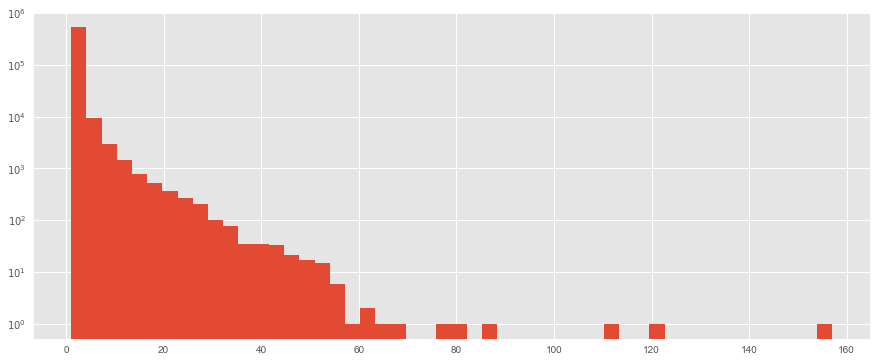

In [10]:
pd.concat([df_train.qid1, df_train.qid2]).value_counts().hist(bins=50)
plt.yscale('log')

Большая часть вопросов почти не повторяется, но около 1% обладают этим свойством, в редких случаях вопросы повторяются более 50 раз. 

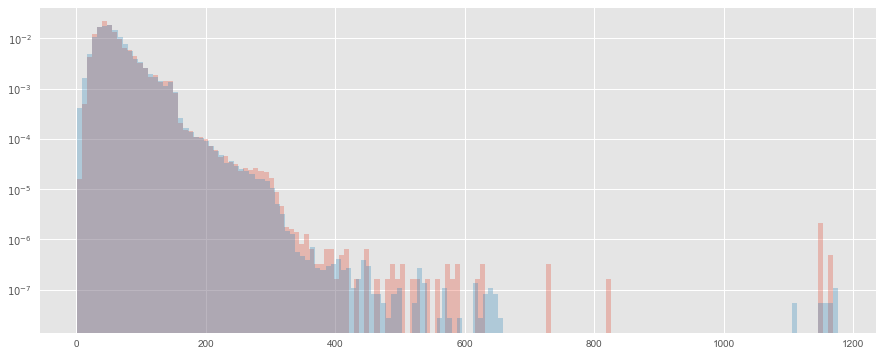

In [11]:
pd.concat([df_train.question1, df_train.question2]).apply(str).apply(len).hist(bins=150, log=True, alpha=0.3, normed=True)
pd.concat([df_test.question1, df_test.question2]).apply(str).apply(len).hist(bins=150, log=True, alpha=0.3, normed=True)

Видно, что распределения по количеству символов в тренировочном и тестовом наборе очень похожи. 

In [4]:
import string, re

In [5]:
regex = re.compile('[%s]' % re.escape(string.punctuation))

In [6]:
regex

re.compile(r'[\!\"\#\$\%\&\\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]')

In [17]:
def word_count(row):
    return len(regex.sub(' ', str(row)).split())

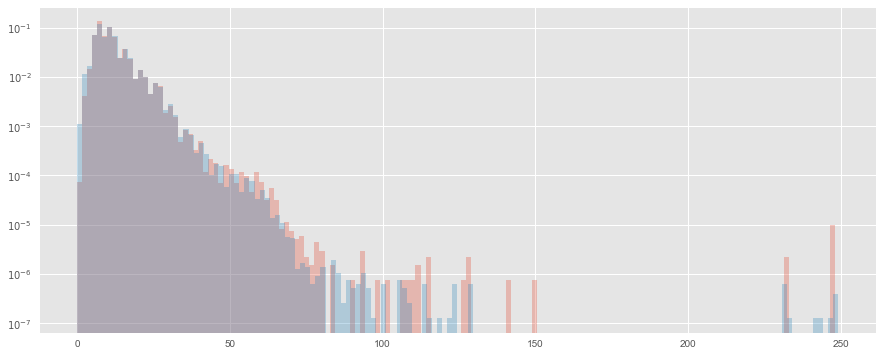

In [18]:
pd.concat([df_train.question1, df_train.question2]).apply(word_count).hist(bins=150, log=True, alpha=0.3, normed=True)
pd.concat([df_test.question1, df_test.question2]).apply(word_count).hist(bins=150, log=True, alpha=0.3, normed=True)

Видно, что распределения по количеству слов в обоих сетах также очень схожи.

In [7]:
corpus = pd.Series(pd.concat([df_train.question1, df_train.question2, df_test.question1,\
                                 df_test.question2]).fillna('').unique())

In [10]:
corpus.shape

(4789032,)

In [8]:
corpus = corpus.apply(lambda x: regex.sub(' ', x))

In [27]:
corpus.head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor  Koh i Noor  Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely  How can I solve...
4    Which one dissolve in water quikly sugar  salt...
dtype: object

Используем TfidfVectorizer для выдления ngram слов длинной от 1 до 5

In [14]:
tfidword = TfidfVectorizer(stop_words='english', ngram_range=(1,5), min_df=50, max_features=300000, max_df=0.999,\
                           binary=True)

In [15]:
tfidword.fit(corpus.values)

TfidfVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.999, max_features=300000, min_df=50,
        ngram_range=(1, 5), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [29]:
tfid1_train = tfidword.transform(df_train.question1.fillna(''))

In [30]:
tfid1_train

<404290x79849 sparse matrix of type '<type 'numpy.float64'>'
	with 2801777 stored elements in Compressed Sparse Row format>

In [31]:
tfid2_train = tfidword.transform(df_train.question2.fillna(''))
tfid1_test = tfidword.transform(df_test.question1.fillna(''))
tfid2_test = tfidword.transform(df_test.question2.fillna(''))

Также посчитаем количество просто ngram длины также от 1 до 5 для каждого вопроса (на самом деле лучше было бы и побольше промежуток взять, но все упирается в память и производительность)

In [9]:
countvchar = CountVectorizer(stop_words='english', ngram_range=(1,5), min_df=50, max_features=300000, max_df=0.999,\
                           binary=True, analyzer='char')

In [10]:
countvchar.fit(corpus.values)

CountVectorizer(analyzer='char', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.999, max_features=300000, min_df=50,
        ngram_range=(1, 5), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [ ]:
cvch1_train = countvchar.transform(df_train.question1.fillna(''))
print 'first complete'
cvch2_train = countvchar.transform(df_train.question2.fillna(''))
print 'second complete'
cvch1_test = countvchar.transform(df_test.question1.fillna(''))
print 'third complete'
cvch2_test = countvchar.transform(df_test.question2.fillna(''))

Получили достаточно большие векторные представления наших вопросов, посчитаем различные метрики схожести

In [37]:
df_train['cos_sim_tf_idf'] = paired_cosine_distances(tfid1_train, tfid2_train)
df_test['cos_sim_tf_idf'] = paired_cosine_distances(tfid1_test, tfid2_test)

In [39]:
df_train['cos_sim_cvc'] = paired_cosine_distances(cvch1_train, cvch2_train)
df_test['cos_sim_cvc'] = paired_cosine_distances(cvch1_test, cvch2_test)

In [157]:
gr = df_train.groupby('is_duplicate')['cos_sim_tf_idf']

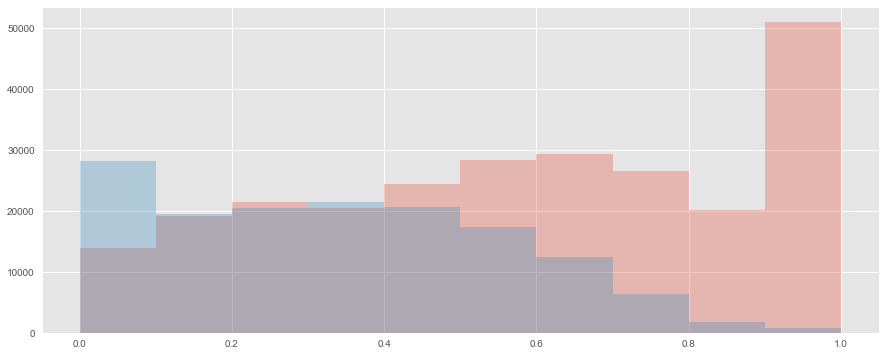

In [158]:
for k,v in gr:
    v.hist(alpha=0.3)

Видно, что признак хороший, неплохо отделяет два класса

Манхетонское и евклидово расстояние лучше нормировать

In [ ]:
df_train['manh_cvc'] = paired_manhattan_distances(cvch1_train, cvch2_train)
df_test['manh_cvc'] = paired_manhattan_distances(cvch1_test, cvch2_test)

cmax = float(max(df_train.manh_cvc.max(), df_test.manh_cvc.max()))
df_train.manh_cvc = df_train.manh_cvc.map(lambda x: x/cmax)
df_test.manh_cvc = df_test.manh_cvc.map(lambda x: x/cmax)

In [ ]:
df_train['euc_cvc'] = paired_euclidean_distances(cvch1_train, cvch2_train)
df_test['euc_cvc'] = paired_euclidean_distances(cvch1_test, cvch2_test)
cmax = float(max(df_train.euc_cvc.max(), df_test.euc_cvc.max()))
df_train.euc_cvc = df_train.euc_cvc.map(lambda x: x/cmax)
df_test.euc_cvc = df_test.euc_cvc.map(lambda x: x/cmax)

In [ ]:
df_train['manh_tfidf'] = paired_manhattan_distances(tfid1_train, tfid2_train)
df_test['manh_tfidf'] = paired_manhattan_distances(tfid1_test, tfid2_test)
cmax = float(max(df_train.manh_tfidf.max(), df_test.manh_tfidf.max()))
df_train.manh_tfidf = df_train.manh_tfidf.map(lambda x: x/cmax)
df_test.manh_tfidf = df_test.manh_tfidf.map(lambda x: x/cmax)

In [ ]:
df_train['euc_tfidf'] = paired_euclidean_distances(tfid1_train, tfid2_train)
df_test['euc_tfidf'] = paired_euclidean_distances(tfid1_test, tfid2_test)
cmax = float(max(df_train.euc_tfidf.max(), df_test.euc_tfidf.max()))
df_train.euc_tfidf = df_train.euc_tfidf.map(lambda x: x/cmax)
df_test.euc_tfidf = df_test.euc_tfidf.map(lambda x: x/cmax)

Посчитаем модуль разности для количества слов для 1го и 2го вопроса для каждой строки, тоже нормируем

In [ ]:
df_train['word_count_dif'] = np.abs(df_train['question1'].apply(word_count) - df_train['question2'].apply(word_count))
df_test['word_count_dif'] = np.abs(df_test['question1'].apply(word_count) - df_test['question2'].apply(word_count))
cmax = float(max(df_train.word_count_dif.max(), df_test.word_count_dif.max()))
df_train['word_count_dif'] = df_train['word_count_dif'].map(lambda x: x/cmax)
df_test['word_count_dif'] = df_test['word_count_dif'].map(lambda x: x/cmax)

В качестве еще одного признака добавим частоту появления вопроса. Как мы видели в начале часть вопросов повторяется, почему бы это не учесть

In [ ]:
df1 = pd.concat([df_train.question1, df_train.question2, df_test.question1, df_test.question2])

In [ ]:
df1.drop_duplicates(inplace=True)

In [ ]:
hash_dict = pd.Series(df1.index, index=df1.values).to_dict()

In [ ]:
df1 = pd.DataFrame(pd.concat([df_train.question1, df_train.question2, \
                              df_test.question1, df_test.question2]), columns=['que'])

In [ ]:
df1['hash'] = df1['que'].map(hash_dict)

In [ ]:
fr_dict = df1['hash'].value_counts().to_dict()

In [ ]:
cmax = float(df1['hash'].value_counts().max())

In [ ]:
df_train['q1_freq'] = df_train['question1'].map(lambda x: fr_dict[hash_dict[x]]/cmax)
df_train['q2_freq'] = df_train['question2'].map(lambda x: fr_dict[hash_dict[x]]/cmax)

In [ ]:
df_test['q1_freq'] = df_test['question1'].map(lambda x: fr_dict[hash_dict[x]]/cmax)
df_test['q2_freq'] = df_test['question2'].map(lambda x: fr_dict[hash_dict[x]]/cmax)

In [21]:
df_train.head().T

,0,1,2,3,4
id,0,1,2,3,4
qid1,1,3,5,7,9
qid2,2,4,6,8,10
question1,What is the step by step guide to invest in sh...,What is the story of Kohinoor (Koh-i-Noor) Dia...,How can I increase the speed of my internet co...,Why am I mentally very lonely? How can I solve...,"Which one dissolve in water quikly sugar, salt..."
question2,What is the step by step guide to invest in sh...,What would happen if the Indian government sto...,How can Internet speed be increased by hacking...,Find the remainder when [math]23^{24}[/math] i...,Which fish would survive in salt water?
is_duplicate,0,0,0,0,0
cos_sim_cvc,0.0515469,0.534254,0.523073,0.887729,0.647002
cos_sim_tf_idf,0.0802818,0.379145,0.846515,1,0.786938
manh_cvc,0.00971284,0.100084,0.114443,0.127111,0.115709
euc_cvc,0.0985537,0.316361,0.338294,0.356527,0.340161


In [23]:
df_test.head().T

,0,1,2,3,4
test_id,0,1,2,3,4
question1,How does the Surface Pro himself 4 compare wit...,Should I have a hair transplant at age 24? How...,What but is the best way to send money from Ch...,Which food not emulsifiers?,"How ""aberystwyth"" start reading?"
question2,Why did Microsoft choose core m3 and not core ...,How much cost does hair transplant require?,What you send money to China?,What foods fibre?,How their can I start reading?
cos_sim_cvc,0.676411,0.450377,0.47032,0.72421,0.357474
cos_sim_tf_idf,0.684591,0.516105,0.467189,1,0
manh_cvc,0.130912,0.0772804,0.0709459,0.0532095,0.0316723
euc_cvc,0.361818,0.277994,0.266357,0.230672,0.177967
word_count_dif,0.0128755,0.0300429,0.0343348,0.00429185,0.00858369
manh_tfidf,0.318105,0.197833,0.221614,0.177159,0
euc_tfidf,0.8274,0.718404,0.683512,1,0


В качестве модели удобно выбрать лог регресию

In [24]:
lr = LogisticRegression(solver='sag', n_jobs=4, max_iter=1000, verbose=2)

Подберем параметры модели

In [26]:
gs = GridSearchCV(lr, {'C': np.linspace(0.1, 1.5, 10)}, scoring='neg_log_loss', verbose=2)

In [33]:
gs.fit(hstack([tfid1_train.astype(float), tfid2_train.astype(float),\
                                 -(tfid1_train.astype(bool) != tfid2_train.astype(bool)).astype(int), \
                                 df_train[['cos_sim_tf_idf', 'word_count_dif', 'cos_sim_cvc', 'euc_cvc', 'manh_cvc',\
                                           'euc_tfidf', 'manh_tfidf']].values]),\
                     df_train.is_duplicate)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=0.1 ...........................................................
convergence after 20 epochs took 8 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    7.9s finished


[CV] ............................................ C=0.1, total=   8.7s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


convergence after 20 epochs took 8 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    8.2s finished


[CV] ............................................ C=0.1, total=   8.9s
[CV] C=0.1 ...........................................................
convergence after 23 epochs took 8 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    8.4s finished


[CV] ............................................ C=0.1, total=   9.1s
[CV] C=0.255555555556 ................................................
convergence after 33 epochs took 12 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   12.0s finished


[CV] ................................. C=0.255555555556, total=  12.7s
[CV] C=0.255555555556 ................................................
convergence after 33 epochs took 13 seconds
[CV] ................................. C=0.255555555556, total=  13.7s

[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   13.1s finished



[CV] C=0.255555555556 ................................................
convergence after 33 epochs took 13 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   13.1s finished


[CV] ................................. C=0.255555555556, total=  13.8s
[CV] C=0.411111111111 ................................................
convergence after 48 epochs took 19 seconds
[CV] ................................. C=0.411111111111, total=  19.8s
[CV] C=0.411111111111 ................................................


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.3s finished


convergence after 49 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.4s finished


[CV] ................................. C=0.411111111111, total=  20.1s
[CV] C=0.411111111111 ................................................
convergence after 48 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.1s finished


[CV] ................................. C=0.411111111111, total=  19.8s
[CV] C=0.566666666667 ................................................
convergence after 60 epochs took 24 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.8s finished


[CV] ................................. C=0.566666666667, total=  24.5s
[CV] C=0.566666666667 ................................................
convergence after 60 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.0s finished


[CV] ................................. C=0.566666666667, total=  19.7s
[CV] C=0.566666666667 ................................................
convergence after 60 epochs took 24 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.9s finished


[CV] ................................. C=0.566666666667, total=  24.6s
[CV] C=0.722222222222 ................................................
convergence after 70 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.1s finished


[CV] ................................. C=0.722222222222, total=  26.8s
[CV] C=0.722222222222 ................................................
convergence after 71 epochs took 29 seconds
[CV] ................................. C=0.722222222222, total=  29.1s
[CV] C=0.722222222222 ................................................


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.6s finished


convergence after 70 epochs took 27 seconds
[CV] ................................. C=0.722222222222, total=  26.8s
[CV] C=0.877777777778 ................................................


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.2s finished


convergence after 79 epochs took 32 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   31.6s finished


[CV] ................................. C=0.877777777778, total=  32.3s
[CV] C=0.877777777778 ................................................
convergence after 79 epochs took 31 seconds
[CV] ................................. C=0.877777777778, total=  31.9s
[CV] C=0.877777777778 ................................................


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   31.3s finished


convergence after 79 epochs took 31 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   31.7s finished


[CV] ................................. C=0.877777777778, total=  32.4s
[CV] C=1.03333333333 .................................................
convergence after 86 epochs took 30 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   30.1s finished


[CV] .................................. C=1.03333333333, total=  30.8s
[CV] C=1.03333333333 .................................................
convergence after 88 epochs took 36 seconds
[CV] .................................. C=1.03333333333, total=  36.8s

[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   36.2s finished



[CV] C=1.03333333333 .................................................
convergence after 87 epochs took 35 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   34.5s finished


[CV] .................................. C=1.03333333333, total=  35.2s
[CV] C=1.18888888889 .................................................
convergence after 93 epochs took 36 seconds
[CV] .................................. C=1.18888888889, total=  37.1s
[CV] C=1.18888888889 .................................................


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   36.5s finished


convergence after 95 epochs took 37 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   37.7s finished


[CV] .................................. C=1.18888888889, total=  38.4s
[CV] C=1.18888888889 .................................................
convergence after 95 epochs took 38 seconds
[CV] .................................. C=1.18888888889, total=  38.5s

[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   37.9s finished



[CV] C=1.34444444444 .................................................
convergence after 102 epochs took 40 seconds
[CV] .................................. C=1.34444444444, total=  41.0s
[CV] C=1.34444444444 .................................................


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   40.4s finished


convergence after 102 epochs took 32 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   31.8s finished


[CV] .................................. C=1.34444444444, total=  32.7s
[CV] C=1.34444444444 .................................................
convergence after 105 epochs took 41 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   41.4s finished


[CV] .................................. C=1.34444444444, total=  42.2s
[CV] C=1.5 ...........................................................
convergence after 108 epochs took 41 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   40.5s finished


[CV] ............................................ C=1.5, total=  41.2s
[CV] C=1.5 ...........................................................
convergence after 108 epochs took 43 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   42.3s finished


[CV] ............................................ C=1.5, total=  42.9s
[CV] C=1.5 ...........................................................
convergence after 114 epochs took 41 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   40.4s finished


[CV] ............................................ C=1.5, total=  41.1s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 13.9min finished


convergence after 62 epochs took 40 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   39.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=2, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([ 0.1    ,  0.25556,  0.41111,  0.56667,  0.72222,  0.87778,
        1.03333,  1.18889,  1.34444,  1.5    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=2)

In [34]:
gs.best_params_

{'C': 0.72222222222222221}

В итоговой модели учтем, что распределения классов в трейн и тест сете разные

In [35]:
lr = LogisticRegression(solver='sag', n_jobs=4, max_iter=1000, verbose=2, C=0.72, class_weight={1: 0.46, 0: 1.32})

In [36]:
lr.fit(hstack([tfid1_train.astype(float), tfid2_train.astype(float),\
              -(tfid1_train.astype(bool) != tfid2_train.astype(bool)).astype(int), \
              df_train[['cos_sim_tf_idf', 'word_count_dif', 'cos_sim_cvc', 'euc_cvc', 'manh_cvc',\
                        'euc_tfidf', 'manh_tfidf', 'q1_freq', 'q2_freq']].values]),\
              df_train.is_duplicate)

convergence after 82 epochs took 41 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   41.6s finished


LogisticRegression(C=0.72, class_weight={0: 1.32, 1: 0.46}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=4, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=2, warm_start=False)

In [37]:
y_pred = lr.predict_proba(hstack([tfid1_test.astype(float), tfid2_test.astype(float),\
                                 -(tfid1_test.astype(bool) != tfid2_test.astype(bool)).astype(int), \
                                 df_test[['cos_sim_tf_idf', 'word_count_dif', 'cos_sim_cvc', 'euc_cvc', 'manh_cvc',\
                                           'euc_tfidf', 'manh_tfidf', 'q1_freq', 'q2_freq']].values]))

In [38]:
df_out = pd.DataFrame(y_pred[:,1], columns=['is_duplicate'])
df_out.index.name = 'test_id'
df_out.to_csv('out8.csv')

В итоге скор: 0.31272